In [1]:
import os
import random

from einops import rearrange
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Reading data

In [2]:
def read_dataset(path, size=128):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode='categorical',
        shuffle=True,
        seed=42,
        image_size=(size, size),
    )
    
    X, y = zip(*ds)
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

In [3]:
train_X, train_y = read_dataset('data/train/')
test_X, test_y = read_dataset('data/test/')
labels = sorted(os.listdir('data/train'))

Found 10019 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


In [4]:
print(labels)

['fish', 'five', 'four', 'mega', 'mirror', 'pyra', 'square', 'squeb', 'three', 'two']


In [5]:
def show_random_images(images, cmap=None):
    choosen = random.choices(images, k=25)
    choosen = rearrange(choosen, '(nh nw) h w c -> (nh h) (nw w) c', nw=5).astype(int)
    plt.imshow(choosen, cmap)

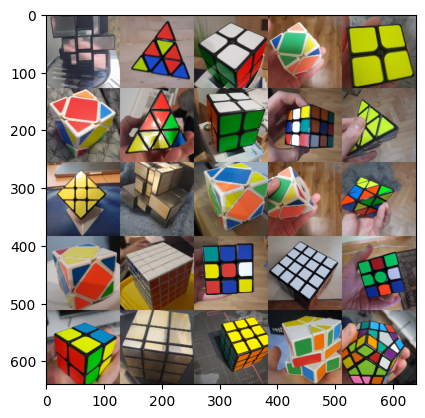

In [100]:
show_random_images(train_X)

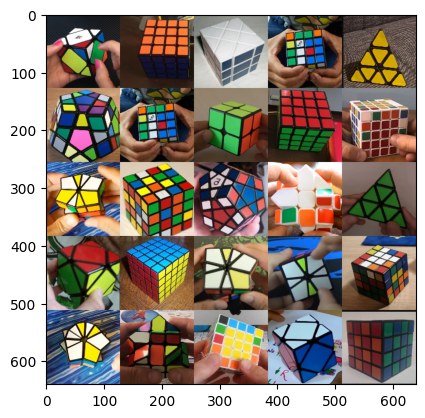

In [98]:
show_random_images(test_X)

### Calculating gradients

In [6]:
def get_gradients(rgb_image):
    gray_image = cv.cvtColor(rgb_image, cv.COLOR_RGB2GRAY) / 256
    
    sobel_x = cv.Sobel(gray_image, cv.CV_64F,1,0,ksize=3)
    sobel_y = cv.Sobel(gray_image, cv.CV_64F,0,1,ksize=3)
    sobel_xy = cv.Sobel(gray_image, cv.CV_64F,1,1,ksize=3)
    sobel_amp = np.sqrt(np.power(sobel_x, 2), np.power(sobel_y, 2))
    
    return [sobel_x, sobel_y, sobel_xy, sobel_amp]

In [7]:
def cvt_to_gradients(images):
    grad_images = []
    for rgb_image in images:
        gradients = get_gradients(rgb_image)
        grad_images.append(gradients)
    grad_images = np.array(grad_images)
    grad_images = np.transpose(grad_images, (0, 2, 3, 1))
    return grad_images

In [8]:
grad_train_X = cvt_to_gradients(train_X)
grad_test_X = cvt_to_gradients(test_X)
grad_train_X.shape, grad_test_X.shape

bin_grad_train_X = np.abs(grad_train_X)
bin_grad_test_X = np.abs(grad_test_X)

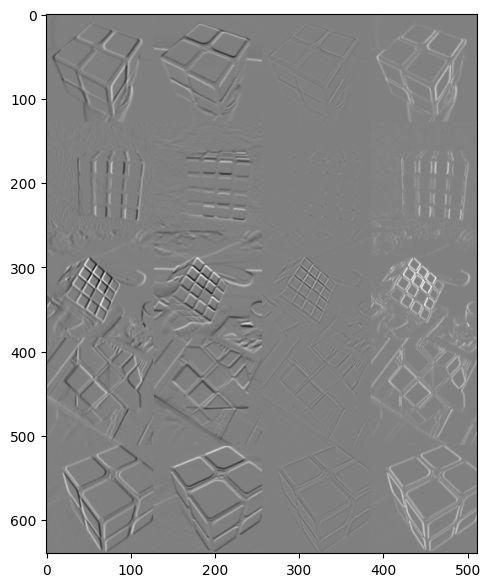

In [9]:
selected_images = random.choices(grad_train_X, k=5)
slices = []
for img in selected_images:
    slice = np.hstack([img[..., 0], img[..., 1], img[..., 2], img[..., 3]])
    slices.append(slice)
    
plt.figure(figsize = (7, 7))
plt.imshow(np.vstack(slices), cmap='gray');

### Creating CNN

In [14]:
model = Sequential([
    layers.Input(shape=(None, None, 4)),
    layers.Resizing(128, 128),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax'),
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 128, 128, 4)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      1184      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)      

In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [17]:
callbacks   = [
      EarlyStopping(monitor='val_categorical_accuracy', patience=10, mode='max'),
      ModelCheckpoint('data/model.tf', monitor='val_categorical_accuracy', save_best_only=True, mode='max'),
]

history = model.fit(
    bin_grad_train_X,
    train_y,
    validation_data=(bin_grad_test_X, test_y),
    epochs=500,
    batch_size=64,
    callbacks=callbacks
)

Epoch 1/500
157/157 [==============================] - ETA: 0s - loss: 2.1346 - categorical_accuracy: 0.1830

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 9s 46ms/step - loss: 2.1346 - categorical_accuracy: 0.1830 - val_loss: 1.7654 - val_categorical_accuracy: 0.3060
Epoch 2/500
157/157 [==============================] - ETA: 0s - loss: 1.2649 - categorical_accuracy: 0.5172

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 44ms/step - loss: 1.2649 - categorical_accuracy: 0.5172 - val_loss: 1.2151 - val_categorical_accuracy: 0.5020
Epoch 3/500
157/157 [==============================] - ETA: 0s - loss: 0.6140 - categorical_accuracy: 0.7698

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 43ms/step - loss: 0.6140 - categorical_accuracy: 0.7698 - val_loss: 1.7419 - val_categorical_accuracy: 0.5320
Epoch 4/500
157/157 [==============================] - ETA: 0s - loss: 0.3158 - categorical_accuracy: 0.8934

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 45ms/step - loss: 0.3158 - categorical_accuracy: 0.8934 - val_loss: 1.2252 - val_categorical_accuracy: 0.6820
Epoch 5/500
157/157 [==============================] - ETA: 0s - loss: 0.1777 - categorical_accuracy: 0.9421

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 43ms/step - loss: 0.1777 - categorical_accuracy: 0.9421 - val_loss: 1.2053 - val_categorical_accuracy: 0.7140
Epoch 6/500
157/157 [==============================] - 6s 37ms/step - loss: 0.1083 - categorical_accuracy: 0.9660 - val_loss: 1.6729 - val_categorical_accuracy: 0.7120
Epoch 7/500
157/157 [==============================] - ETA: 0s - loss: 0.0989 - categorical_accuracy: 0.9694

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 43ms/step - loss: 0.0989 - categorical_accuracy: 0.9694 - val_loss: 1.6984 - val_categorical_accuracy: 0.7240
Epoch 8/500
157/157 [==============================] - ETA: 0s - loss: 0.0595 - categorical_accuracy: 0.9828

INFO:tensorflow:Assets written to: data\model.tf\assets


INFO:tensorflow:Assets written to: data\model.tf\assets


157/157 [==============================] - 7s 43ms/step - loss: 0.0595 - categorical_accuracy: 0.9828 - val_loss: 1.5321 - val_categorical_accuracy: 0.7680
Epoch 9/500
157/157 [==============================] - 6s 37ms/step - loss: 0.0718 - categorical_accuracy: 0.9778 - val_loss: 2.1198 - val_categorical_accuracy: 0.6980
Epoch 10/500
157/157 [==============================] - 6s 37ms/step - loss: 0.0657 - categorical_accuracy: 0.9806 - val_loss: 1.6498 - val_categorical_accuracy: 0.6980
Epoch 11/500
157/157 [==============================] - 6s 37ms/step - loss: 0.0434 - categorical_accuracy: 0.9866 - val_loss: 1.8450 - val_categorical_accuracy: 0.7340
Epoch 12/500
157/157 [==============================] - 6s 38ms/step - loss: 0.0439 - categorical_accuracy: 0.9872 - val_loss: 1.8158 - val_categorical_accuracy: 0.7000
Epoch 13/500
157/157 [==============================] - 6s 37ms/step - loss: 0.0402 - categorical_accuracy: 0.9884 - val_loss: 2.0095 - val_categorical_accuracy: 0.7460


### Results

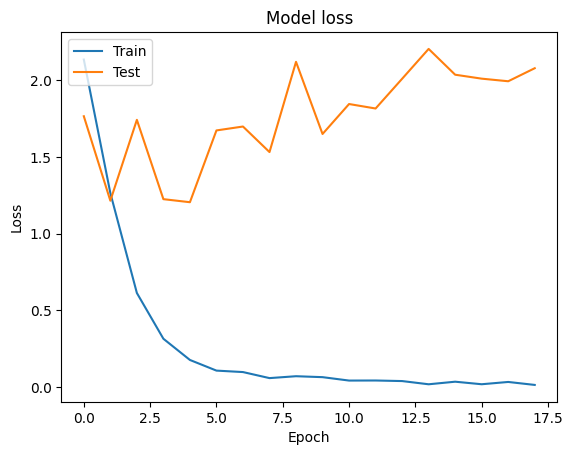

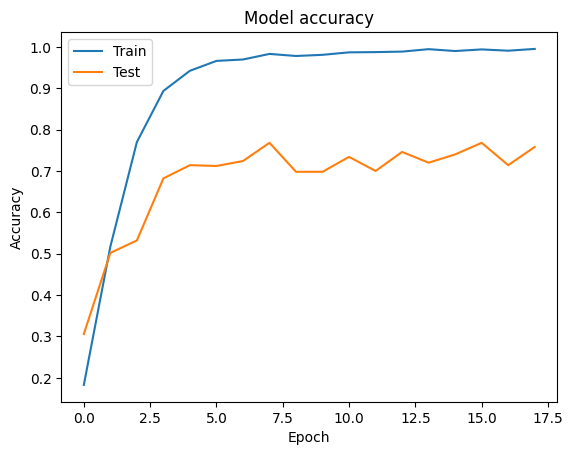

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

16/16 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.49      0.62      0.55        50
           1       0.74      0.80      0.77        50
           2       0.56      0.60      0.58        50
           3       0.93      0.76      0.84        50
           4       0.56      0.72      0.63        50
           5       1.00      1.00      1.00        50
           6       0.88      0.76      0.82        50
           7       0.98      0.96      0.97        50
           8       0.73      0.66      0.69        50
           9       0.95      0.70      0.80        50

    accuracy                           0.76       500
   macro avg       0.78      0.76      0.76       500
weighted avg       0.78      0.76      0.76       500



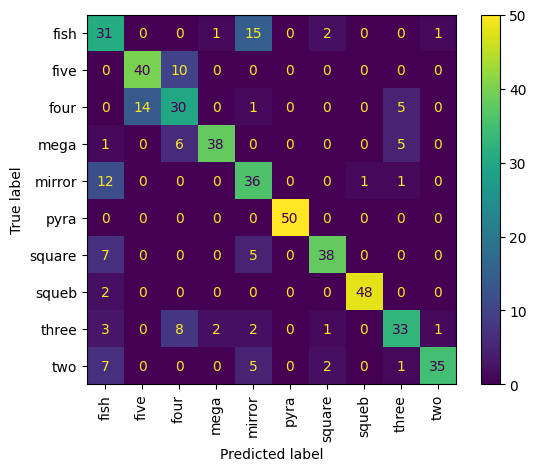

In [19]:
predictions = model.predict(bin_grad_test_X)
true_classes = np.argmax(test_y, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    display_labels=labels, 
    xticks_rotation='vertical',
);